# Introduction to the Python Control Systems Library (python-control)

## Input/Output Systems

Richard M. Murray, 13 Nov 2021 (updated 5 Jan 2023)

This notebook contains an introduction to the basic operations in the Python Control Systems Library (python-control), a Python package for control system design.  This notebook is focused on state space control design for a kinematic car, including trajectory generation and gain-scheduled feedback control.  This illustrates the use of the input/output (I/O) system class, which can be used to construct models for nonlinear control systems.

In [2]:
# Import the packages needed for the examples included in this notebook
import numpy as np
import matplotlib.pyplot as plt
import control as ct
print("python-control version:", ct.__version__)

python-control version: 0.9.4


### Installation hints

If you get an error importing the `control` package, it may be that it is not in your current Python path.  You can fix this by setting the PYTHONPATH environment variable to include the directory where the python-control package is located.  If you are invoking Jupyter from the command line, try using a command of the form

    PYTHONPATH=/path/to/control jupyter notebook
    
If you are using [Google Colab](https://colab.research.google.com), use the following command at the top of the notebook to install the `control` package:

    !pip install control
    
For the examples below, you will need version 0.9.3 or higher of the python-control toolbox.  You can find the version number using the command

    print(ct.__version__)

### More information on Python, NumPy, python-control

* [Python tutorial](https://docs.python.org/3/tutorial/)
* [NumPy tutorial](https://numpy.org/doc/stable/user/quickstart.html)
* [NumPy for MATLAB users](https://numpy.org/doc/stable/user/numpy-for-matlab-users.html), 
* [Python Control Systems Library (python-control) documentation](https://python-control.readthedocs.io/en/0.9.3.post2/)

## System Definiton

We now define the dynamics of the system that we are going to use for the control design.  The dynamics of the system will be of the form

$$
\dot x = f(x, u), \qquad y = h(x, u)
$$

where $x$ is the state vector for the system, $u$ represents the vector of inputs, and $y$ represents the vector of outputs.

The python-control package allows definition of input/output sytems using the `InputOutputSystem` class and its various subclasess, including the `NonlinearIOSystem` class that we use here.  A `NonlinearIOSystem` object is created by defining the update law ($f(x, u)$) and the output map ($h(x, u)$).

For the example in this notebook, we will be controlling the steering of a vehicle, using a "bicycle" model for the dynamics of the vehicle.  A more complete description of the dynamics of this system are available in [Example 3.11](https://fbswiki.org/wiki/index.php/System_Modeling) of [_Feedback Systems_](https://fbswiki.org/wiki/index.php/FBS) by Astrom and Murray (2020).

In [3]:
# Define the update rule for the system, f(x, u)
# States: x, y, theta (postion and angle of the center of mass)
# Inputs: v (forward velocity), delta (steering angle)
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    a = params.get('refoffset', 1.5)        # offset to vehicle reference point
    b = params.get('wheelbase', 3.)         # vehicle wheelbase
    maxsteer = params.get('maxsteer', 0.5)  # max steering angle (rad)

    # Saturate the steering input
    delta = np.clip(u[1], -maxsteer, maxsteer)
    alpha = np.arctan2(a * np.tan(delta), b)

    # Return the derivative of the state
    return np.array([
        u[0] * np.cos(x[2] + alpha),    # xdot = cos(theta + alpha) v
        u[0] * np.sin(x[2] + alpha),    # ydot = sin(theta + alpha) v
        (u[0] / a) * np.sin(alpha)      # thdot = v sin(alpha) / a
    ])

# Define the readout map for the system, h(x, u)
# Outputs: x, y (planar position of the center of mass)
def vehicle_output(t, x, u, params):
    return x

# Default vehicle parameters (including nominal velocity)
vehicle_params={'refoffset': 1.5, 'wheelbase': 3, 'velocity': 15, 
                'maxsteer': 0.5}

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=['v', 'delta'], outputs=['x', 'y', 'theta'], params=vehicle_params)

## Open loop simulation

After these operations, the `vehicle` object references the nonlinear model for the system.  This system can be simulated to compute a trajectory for the system.  Here we command a velocity of 10 m/s and turn the wheel back and forth at one Hertz.

In [4]:
# Define the time interval that we want to use for the simualation
timepts = np.linspace(0, 10, 1000)

# Define the inputs
U = [
    10 * np.ones_like(timepts),          # velocity
    0.1 * np.sin(timepts * 2*np.pi)      # steering angle
]

# Simulate the system dynamics, starting from the origin
time, outputs = ct.input_output_response(vehicle, timepts, U, 0)

We plot the results using standard `matplotlib` commands:

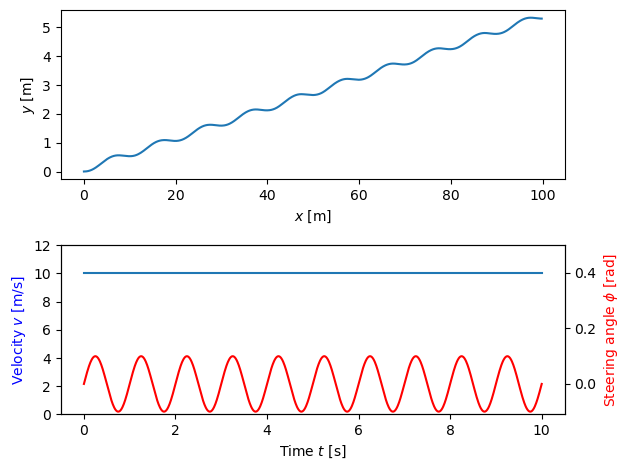

In [5]:
# Create a figure to plot the results
fig, ax = plt.subplots(2, 1)

# Plot the results in the xy plane
ax[0].plot(outputs[0], outputs[1])
ax[0].set_xlabel("$x$ [m]")
ax[0].set_ylabel("$y$ [m]")

# Plot the inputs
ax[1].plot(timepts, U[0])
ax[1].set_ylim(0, 12)
ax[1].set_xlabel("Time $t$ [s]")
ax[1].set_ylabel("Velocity $v$ [m/s]")
ax[1].yaxis.label.set_color('blue')

rightax = ax[1].twinx()       # Create an axis in the right
rightax.plot(timepts, U[1], color='red')
rightax.set_ylim(None, 0.5)
rightax.set_ylabel("Steering angle $\phi$ [rad]")
rightax.yaxis.label.set_color('red')

fig.tight_layout()

Notice that there is a small drift in the $y$ position despite the fact that the steering wheel is moved back and forth symmetrically around zero.  Exercise: explain what might be happening.

## Linearize the system around a trajectory

We choose a straight path along the $x$ axis at a speed of 10 m/s as our desired trajectory and then linearize the dynamics around the initial point in that that trajectory.

In [6]:
# Create the desired trajectory 
Ud = np.array([10 * np.ones_like(timepts), np.zeros_like(timepts)])
Xd = np.array([10 * timepts, 0 * timepts, np.zeros_like(timepts)])

# Now linizearize the system around this trajectory
linsys = vehicle.linearize(Xd[:, 0], Ud[:, 0])

In [7]:
# Check on the eigenvalues of the open loop system
np.linalg.eigvals(linsys.A)

array([0., 0., 0.])

We see that all eigenvalues are zero, corresponding to a single integrator in the $x$ (longitudinal) direction and a double integrator in the $y$ (lateral) direction.

## Compute a state space (LQR) control law

We can now compute a feedback controller around the trajectory.  We choose a simple LQR controller here, but any method can be used.

In [9]:
# Compute LQR controller
K, S, E = ct.lqr(linsys, np.diag([1, 1, 1]), np.diag([1, 1]))

In [10]:
# Check on the eigenvalues of the closed loop system
np.linalg.eigvals(linsys.A - linsys.B @ K)

array([-1.        +0.j        , -5.06896878+2.76385399j,
       -5.06896878-2.76385399j])

The closed loop eigenvalues have negative real part, so the closed loop (linear) system will be stable about the operating trajectory.

## Create a controller with feedforward and feedback

We now create an I/O system representing the control law.  The controller takes as an input the desired state space trajectory $x_\text{d}$ and the nominal input $u_\text{d}$.  It outputs the control law

$$
u = u_\text{d} - K(x - x_\text{d}).
$$

In [11]:
# Define the output rule for the controller
# States: none (=> no update rule required)
# Inputs: z = [xd, ud, x]
# Outputs: v (forward velocity), delta (steering angle)
def control_output(t, x, z, params):
    # Get the parameters for the model
    K = params.get('K', np.zeros((2, 3)))   # nominal gain
    
    # Split up the input to the controller into the desired state and nominal input
    xd_vec = z[0:3]    # desired state ('xd', 'yd', 'thetad')
    ud_vec = z[3:5]    # nominal input ('vd', 'deltad')
    x_vec = z[5:8]     # current state ('x', 'y', 'theta')
    
    # Compute the control law
    return ud_vec - K @ (x_vec - xd_vec)

# Define the controller system
control = ct.NonlinearIOSystem(
    None, control_output, name='control',
    inputs=['xd', 'yd', 'thetad', 'vd', 'deltad', 'x', 'y', 'theta'], 
    outputs=['v', 'delta'], params={'K': K})

Because we have named the signals in both the vehicle model and the controller in a compatible way, we can use the autoconnect feature of the `interconnect()` function to create the closed loop system.

In [12]:
# Build the closed loop system
vehicle_closed = ct.interconnect(
    (vehicle, control),
    inputs=['xd', 'yd', 'thetad', 'vd', 'deltad'],
    outputs=['x', 'y', 'theta']
)

## Closed loop simulation

We now command the system to follow in trajectory and use the linear controller to correct for any errors. 

The desired trajectory is a given by a longitudinal position that tracks a velocity of 10 m/s for the first 5 seconds and then increases to 12 m/s and a lateral position that varies sinusoidally by $\pm 0.5$ m around the centerline.  The nominal inputs are not modified, so that feedback is required to obtained proper trajectory tracking.

In [13]:
Xd = np.array([
    10 * timepts + 2 * (timepts-5) * (timepts > 5), 
    0.5 * np.sin(timepts * 2*np.pi), 
    np.zeros_like(timepts)
])

Ud = np.array([10 * np.ones_like(timepts), np.zeros_like(timepts)])

# Simulate the system dynamics, starting from the origin
resp = ct.input_output_response(
    vehicle_closed, timepts, np.vstack((Xd, Ud)), 0)
time, outputs = resp.time, resp.outputs

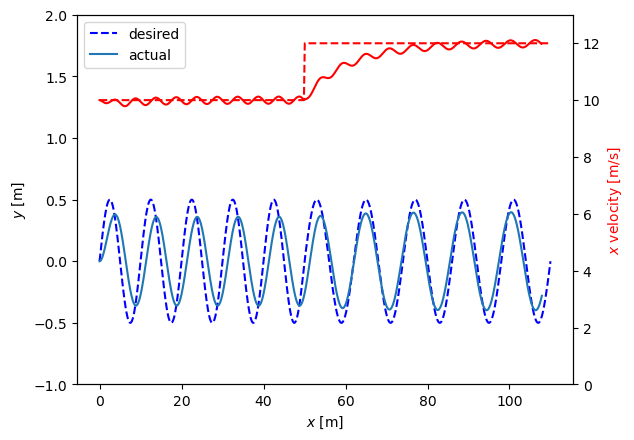

In [14]:
# Plot the results in the xy plane
plt.plot(Xd[0], Xd[1], 'b--')      # desired trajectory
plt.plot(outputs[0], outputs[1])   # actual trajectory
plt.xlabel("$x$ [m]")
plt.ylabel("$y$ [m]")
plt.ylim(-1, 2)

# Add a legend
plt.legend(['desired', 'actual'], loc='upper left')

# Compute and plot the velocity
rightax = plt.twinx()       # Create an axis in the right
rightax.plot(Xd[0, :-1], np.diff(Xd[0]) / np.diff(timepts), 'r--')
rightax.plot(outputs[0, :-1], np.diff(outputs[0]) / np.diff(timepts), 'r-')
rightax.set_ylim(0, 13)
rightax.set_ylabel("$x$ velocity [m/s]")
rightax.yaxis.label.set_color('red')

We see that there is a small error in each axis.  By adjusting the weights in the LQR controller we can adjust the steady state error (try it!)